In [1]:
from __future__ import annotations
from pathlib import Path
from typing import List, Dict
import re
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.api.types import CategoricalDtype
import xlsxwriter
from openpyxl import Workbook
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.contingency_tables import Table2x2
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, shapiro, mannwhitneyu
from sklearn.metrics import roc_auc_score

In [2]:
# 1. Chargement et suppression de la ligne description
df = pd.read_excel('../data/REACT-HF_v2_06102025.xlsx')
df_raw = df.iloc[1:].copy()

In [3]:
# 2. Suppression des colonnes sans données
drop_cols = [
    'MODE_DE_VIE'
]
df_raw = df_raw.drop(columns=drop_cols)

# 3. Renommage de quelques colonnes
df_raw = df_raw.rename(columns={
    'PRESENCE_ISGLT2_FEVG>50%': 'PRESENCE_ISGLT2_FEVG_sup50',
    '>/=3_FANTASTIQUES_FEVG<50%': 'FANTASTIQUES_3_FEVG_inf50',
    'ANEMIE_HB<10g/l':'ANEMIE_HB_inf10_gl',
    'PRESENCE_BB-':            'PRESENCE_BB',
    'PRESENCE_IECi/ARA2':    'PRESENCE_IECi_ARA2',
    'NT-PRO_BNP_SORTIE': 'NT_PRO_BNP_SORTIE',
    'ATCD_FA/FLUTTER': 'ATCD_FA_FLUTTER',
    'PM/DAI': 'PM_DAI'
})

In [4]:
# 3. Changegment des modalités
cols_to_recode = ['MODE_ADMISSION', 'MODE_READMISSION_IC']

for col in cols_to_recode:
    # Convertir en string explicite (sécurisé même si c'est déjà string)
    df_raw[col] = df_raw[col].astype(str)

    # Fusionner les modalités 0 et 2, garder 1
    df_raw[col] = df_raw[col].map({
        '0': '0',
        '2': '0',
        '1': '1'
    })


In [5]:
# 4. Définition des listes de variables par type
char_cols    = ['NUMERO_PATIENT']

integer_cols = ['AGE','DMS','SCORE_CHARLSON','NT_PRO_BNP_SORTIE','FERRITINE','DOSAGE_SORTIE_DIURETIC', 'DMS_REHOSPITALISATION_IC',
                'NBRE_REHOSPITALISATION_IC_12MOIS']

double_cols  = ['ADL','IMC','ALBUMINE']

percent_cols = ['HbA1c','CST']

bool_vars    = [
    'SEXE','OBESITE','DENUTRITION_CONFIRMEE','CHARLSON>6','SYNDROME_DEPRESSIF','TROUBLES_COGNITIFS_SEVERES','ATCD_CANCER','CANCER_ACTIF',
    'ATCD_BPCO','ATCD_HTA','ATCD_DYSLIPIDEMIE','ATCD_DIABETE','ATCD_AVC','ATCD_AOMI','ATCD_FA_FLUTTER',
    'ATCD_AMYLOSE','PM_DAI','RAC_AU_MOINS_MODEREE','IM_AU_MOINS_MODEREE','IT_AU_MOINS_MODEREE','ALBUMINE<35',"DFG<45","NTproBNP>5000",
    'CARENCE_MARTIALE_VRAIE','CARENCE_MARTIALE_FONCTIONNELLE','ANEMIE_HB_inf10_gl','CARENCE_VITAMINE_B9',
    'CARENCE_VITAMINE_B12','CARENCE_VITAMINE_D','PRESENCE_IECi_ARA2','PRESENCE_ACEi','PRESENCE_BB',
    'PRESENCE_MRA','PRESENCE_SORTIE_ISGLT2','PRESENCE_SORTIE_DIURETIC','PRESENCE_SORTIE_ANTICOAGULANT',
    'PRESENCE_SORTIE_AAP','PRESENCE_ISGLT2_FEVG_sup50','FANTASTIQUES_3_FEVG_inf50','OUTCOME_REHOSPITALISATION_12MOIS'
]
ordinal_mappings = {
    'DENUTRITION': {'0':'Risque dénutrition','1':'Dénutrition modérée','2':'Dénutrition sévère','NC':'Inconnu'},
    'ATCD_CARDIOPATHIE_ISCHEMIQUE': {'0':'NON','1':'Traitement médical','2':'Angioplastie stent','3':'Pontage'},
    'FEVG_CLASSE': {'0':'Altérée (</=40%)','1':'Moyennement altérée (41-49%)','2':'Préservée (>/=50%)'},
    'STADE_IRC_DFG_SORTIE': {'1':'DFG>90 ml/min','2':'DFG=60-89 ml/min','3A':'45-59 ml/min','3B':'30-44 ml/min','4':'15-29 ml/min','5':'<14 ml/min'},
    'TYPE_DIURETIC': {'0':'FUROSEMIDE','1':'BUMETAMIDE'},
    'TYPE_SUIVI_SATELIA': {'0':'Patient','1':'Aidant', '2':'IDEL','3':'Satelia'},
    'MODE_ADMISSION' : {'0':'SAU & transfert MCO', '1':'admission directe'},
    'MODE_READMISSION_IC' : {'0':'SAU & transfert MCO', '1':'admission directe'}
}
rehosp_cols = [
    'REHOSPITALISATION_IC_1MOIS','REHOSPITALISATION_IC_3MOIS',
    'REHOSPITALISATION_IC_6MOIS','REHOSPITALISATION_IC_12MOIS'
]

In [6]:
# 5. Application des transformations
df_clean = df_raw.copy()

# → Caractères
for col in char_cols:
    df_clean[col] = df_clean[col].astype(str)

# → Doubles (correction : on force en str avant le .str.strip())
for col in double_cols:
    df_clean[col] = pd.to_numeric(
        df_clean[col].astype(str).str.strip().replace('NC', pd.NA),
        errors='coerce'
    )

# → Entiers (extraction de chiffres puis Int64 pour garder les NA)
for col in integer_cols:
    df_clean[col] = df_clean[col].astype(str).str.extract(r'(\d+)', expand=False)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').astype('Int64')

# → Pourcentages
for col in percent_cols:
    df_clean[col] = df_clean[col].astype(str).str.replace('%','').str.strip().replace('NC', pd.NA)
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# → Booléens en catégories “No”/“Yes”
bool_map = {'1':True,'0':False,1:True,0:False,True:True,False:False}
for col in bool_vars:
    df_clean[col] = df_clean[col].map(bool_map)
    df_clean[col] = df_clean[col].map({False:'No',True:'Yes'}).astype('category')

# → Réhospitalisations
for col in rehosp_cols:
    # 1) on force en numérique (les NC, '', etc. deviennent NaN)
    num = pd.to_numeric(df_clean[col], errors='coerce')
    # 2) on mappe 1→Yes, 0→No
    df_clean[col] = num.map({1:'Yes', 0:'No'}).astype('category')

# → Variables ordinales
for col, mapping in ordinal_mappings.items():
    cat_type = CategoricalDtype(categories=list(mapping.values()), ordered=True)
    df_clean[col] = df_clean[col].astype(str).map(mapping).astype(cat_type)


In [7]:
# 6. Vérification rapide
df_clean.head()

,NUMERO_PATIENT,DDN,DATE_ADMISSION,NB_MOIS_SUIVI,AGE,AGE>85,SEXE,MODE_ADMISSION,DMS,ADL,...,PRESENCE_SORTIE_AAP,TYPE_SUIVI_SATELIA,OUTCOME_REHOSPITALISATION_12MOIS,REHOSPITALISATION_IC_1MOIS,REHOSPITALISATION_IC_3MOIS,REHOSPITALISATION_IC_6MOIS,REHOSPITALISATION_IC_12MOIS,DMS_REHOSPITALISATION_IC,MODE_READMISSION_IC,NBRE_REHOSPITALISATION_IC_12MOIS
1,1.0,1941-01-01,2024-07-16,13.0,83,0,No,SAU & transfert MCO,5,4.5,...,No,Satelia,Yes,No,No,No,No,<NA>,NaN,0
2,2.0,1943-12-11,2024-03-22,13.0,80,0,No,SAU & transfert MCO,7,5.5,...,No,Satelia,Yes,No,No,No,Yes,<NA>,NaN,1
3,3.0,1941-10-13,2024-06-26,15.0,82,0,No,SAU & transfert MCO,6,5.5,...,No,Patient,Yes,No,No,No,Yes,8,SAU & transfert MCO,1
4,4.0,1929-09-27,2023-12-05,21.0,94,1,Yes,SAU & transfert MCO,6,5.5,...,Yes,Aidant,No,No,No,No,No,<NA>,NaN,0
5,5.0,1944-01-25,2024-05-29,16.0,80,0,No,SAU & transfert MCO,6,6.0,...,No,Satelia,Yes,No,No,No,Yes,8,SAU & transfert MCO,1


In [8]:
print(df_clean.dtypes)

NUMERO_PATIENT                              object
DDN                                 datetime64[ns]
DATE_ADMISSION                      datetime64[ns]
NB_MOIS_SUIVI                              float64
AGE                                          Int64
                                         ...      
REHOSPITALISATION_IC_6MOIS                category
REHOSPITALISATION_IC_12MOIS               category
DMS_REHOSPITALISATION_IC                     Int64
MODE_READMISSION_IC                       category
NBRE_REHOSPITALISATION_IC_12MOIS             Int64
Length: 71, dtype: object


In [9]:
# Fonction pour calculer la proportion de NA et ne conserver que les colonnes à NA > 0
def na_props(df, cols):
    # isna().mean() donne la proportion de NA par colonne
    props = df[cols].isna().mean()
    return props[props > 0]

# Appliquer à chaque groupe de colonnes
integer_na   = na_props(df_clean, integer_cols)
double_na    = na_props(df_clean, double_cols)
percent_na   = na_props(df_clean, percent_cols)
bool_na      = na_props(df_clean, bool_vars)
rehosp_na    = na_props(df_clean, rehosp_cols)
ordinal_na   = na_props(df_clean, list(ordinal_mappings.keys()))

# Afficher le résultat
missing_summary = {
    'integer'          : integer_na,
    'double'           : double_na,
    'percent'          : percent_na,
    'boolean'          : bool_na,
    'rehospitalisation': rehosp_na,
    'ordinal'          : ordinal_na
}

for group, series in missing_summary.items():
    print(f"\n– {group} cols with NA > 0:")
    print(series)



– integer cols with NA > 0:
NT_PRO_BNP_SORTIE                   0.019608
FERRITINE                           0.054902
DOSAGE_SORTIE_DIURETIC              0.074510
DMS_REHOSPITALISATION_IC            0.737255
NBRE_REHOSPITALISATION_IC_12MOIS    0.023529
dtype: float64

– double cols with NA > 0:
ALBUMINE    0.007843
dtype: float64

– percent cols with NA > 0:
HbA1c    0.207843
CST      0.066667
dtype: float64

– boolean cols with NA > 0:
DENUTRITION_CONFIRMEE             0.003922
ATCD_HTA                          0.003922
RAC_AU_MOINS_MODEREE              0.015686
IM_AU_MOINS_MODEREE               0.015686
IT_AU_MOINS_MODEREE               0.019608
ALBUMINE<35                       0.007843
NTproBNP>5000                     0.019608
CARENCE_MARTIALE_VRAIE            0.054902
CARENCE_MARTIALE_FONCTIONNELLE    0.054902
CARENCE_VITAMINE_B9               0.054902
CARENCE_VITAMINE_B12              0.054902
CARENCE_VITAMINE_D                0.039216
PRESENCE_ISGLT2_FEVG_sup50        0.388235

In [10]:
# Variables ordinales (noms uniquement)
ordinal_vars = [
    'DENUTRITION', 'ATCD_CARDIOPATHIE_ISCHEMIQUE', 'FEVG_CLASSE',
    'STADE_IRC_DFG_SORTIE', 'TYPE_DIURETIC', 'TYPE_SUIVI_SATELIA'
]

# Variables "spéciales"
special_vars = [
    'PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50',
    'MODE_ADMISSION', 'MODE_READMISSION_IC'
]

# On retire special_vars de la liste des booléens
bool_wo_special = [col for col in bool_vars if col not in special_vars]

# Variables continues
cont_vars = double_cols + integer_cols + percent_cols

# Variables catégorielles (booléennes non spéciales + ordinales + spéciales)
cat_vars_initial = bool_wo_special + ordinal_vars + special_vars

# 1. Vos vraies binaires (sans les ordinales)
cat_vars = [col for col in cat_vars_initial if col not in ordinal_vars]

all_vars = cont_vars + cat_vars + ordinal_vars

horizons = rehosp_cols[:4]

# Affichage des listes
print("cont_vars:", cont_vars)
print("\ncat_vars_all:", cat_vars_initial )
print("\nhorizons:", horizons)

cont_vars: ['ADL', 'IMC', 'ALBUMINE', 'AGE', 'DMS', 'SCORE_CHARLSON', 'NT_PRO_BNP_SORTIE', 'FERRITINE', 'DOSAGE_SORTIE_DIURETIC', 'DMS_REHOSPITALISATION_IC', 'NBRE_REHOSPITALISATION_IC_12MOIS', 'HbA1c', 'CST']

cat_vars_all: ['SEXE', 'OBESITE', 'DENUTRITION_CONFIRMEE', 'CHARLSON>6', 'SYNDROME_DEPRESSIF', 'TROUBLES_COGNITIFS_SEVERES', 'ATCD_CANCER', 'CANCER_ACTIF', 'ATCD_BPCO', 'ATCD_HTA', 'ATCD_DYSLIPIDEMIE', 'ATCD_DIABETE', 'ATCD_AVC', 'ATCD_AOMI', 'ATCD_FA_FLUTTER', 'ATCD_AMYLOSE', 'PM_DAI', 'RAC_AU_MOINS_MODEREE', 'IM_AU_MOINS_MODEREE', 'IT_AU_MOINS_MODEREE', 'ALBUMINE<35', 'DFG<45', 'NTproBNP>5000', 'CARENCE_MARTIALE_VRAIE', 'CARENCE_MARTIALE_FONCTIONNELLE', 'ANEMIE_HB_inf10_gl', 'CARENCE_VITAMINE_B9', 'CARENCE_VITAMINE_B12', 'CARENCE_VITAMINE_D', 'PRESENCE_IECi_ARA2', 'PRESENCE_ACEi', 'PRESENCE_BB', 'PRESENCE_MRA', 'PRESENCE_SORTIE_ISGLT2', 'PRESENCE_SORTIE_DIURETIC', 'PRESENCE_SORTIE_ANTICOAGULANT', 'PRESENCE_SORTIE_AAP', 'OUTCOME_REHOSPITALISATION_12MOIS', 'DENUTRITION', 'ATCD_C

In [11]:
print(cat_vars)

['SEXE', 'OBESITE', 'DENUTRITION_CONFIRMEE', 'CHARLSON>6', 'SYNDROME_DEPRESSIF', 'TROUBLES_COGNITIFS_SEVERES', 'ATCD_CANCER', 'CANCER_ACTIF', 'ATCD_BPCO', 'ATCD_HTA', 'ATCD_DYSLIPIDEMIE', 'ATCD_DIABETE', 'ATCD_AVC', 'ATCD_AOMI', 'ATCD_FA_FLUTTER', 'ATCD_AMYLOSE', 'PM_DAI', 'RAC_AU_MOINS_MODEREE', 'IM_AU_MOINS_MODEREE', 'IT_AU_MOINS_MODEREE', 'ALBUMINE<35', 'DFG<45', 'NTproBNP>5000', 'CARENCE_MARTIALE_VRAIE', 'CARENCE_MARTIALE_FONCTIONNELLE', 'ANEMIE_HB_inf10_gl', 'CARENCE_VITAMINE_B9', 'CARENCE_VITAMINE_B12', 'CARENCE_VITAMINE_D', 'PRESENCE_IECi_ARA2', 'PRESENCE_ACEi', 'PRESENCE_BB', 'PRESENCE_MRA', 'PRESENCE_SORTIE_ISGLT2', 'PRESENCE_SORTIE_DIURETIC', 'PRESENCE_SORTIE_ANTICOAGULANT', 'PRESENCE_SORTIE_AAP', 'OUTCOME_REHOSPITALISATION_12MOIS', 'PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50', 'MODE_ADMISSION', 'MODE_READMISSION_IC']


In [12]:
print(ordinal_vars)

['DENUTRITION', 'ATCD_CARDIOPATHIE_ISCHEMIQUE', 'FEVG_CLASSE', 'STADE_IRC_DFG_SORTIE', 'TYPE_DIURETIC', 'TYPE_SUIVI_SATELIA']


In [13]:
for h in horizons:
    print(f"Horizon {h!r} → modalities:", df_clean[h].value_counts(dropna=False).to_dict())


Horizon 'REHOSPITALISATION_IC_1MOIS' → modalities: {'No': 246, 'Yes': 9}
Horizon 'REHOSPITALISATION_IC_3MOIS' → modalities: {'No': 230, 'Yes': 25}
Horizon 'REHOSPITALISATION_IC_6MOIS' → modalities: {'No': 214, 'Yes': 41}
Horizon 'REHOSPITALISATION_IC_12MOIS' → modalities: {'No': 192, 'Yes': 63}


In [14]:
confounders  = ["AGE", "SEXE", "ATCD_HTA", "SCORE_CHARLSON", 
              "IM_AU_MOINS_MODEREE", "CARENCE_MARTIALE_VRAIE"]

special_bools = ['PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50']

# Nouvelle Etude

In [41]:
"""
Univariate & Multivariate Readmission Analysis
--------------------------------------------------
Améliorations par rapport à la v1 :
• Suppression de la logique « special_vars »
• Tests continus : choix Welch vs Mann–Whitney
• IC 95 % : Student t / bootstrap
• Colonne `test_used` + `add_stat_label` pour suffixes Mean (SD) ou Median [IQR]
• Ajustement multivarié : GLM logit, Wald vs LRT
• Diagnostics : AUC/ROC, VIF, Box–Tidwell
• Export Excel : 1 onglet / horizon, titres figés, p<0.05 en rouge

Entrées attendues :
    df_clean : DataFrame nettoyé
    horizons, cont_vars, ordinal_vars, bool_vars, confounders
"""

# 1) Tests & IC helpers
# ----------------------
def _is_normal(x: pd.Series, alpha: float = 0.05) -> bool:
    x = pd.to_numeric(x, errors="coerce").dropna().astype(float)
    if len(x) < 3 or x.nunique() <= 1 or np.isclose(x.var(ddof=0), 0):
        return True
    n = len(x)
    if n < 50:
        p = stats.shapiro(x)[1]
    else:
        p = stats.normaltest(x)[1]
        if n >= 5000 and p < alpha:
            skew, kurt = stats.skew(x), stats.kurtosis(x, fisher=False)
            if abs(skew) < 1 and abs(kurt - 3) < 1:
                p = alpha + 0.01
    return p > alpha


def _welch_ci(x: np.ndarray, alpha: float = 0.05) -> tuple[float, float]:
    m, s, n = x.mean(), x.std(ddof=1), len(x)
    se = s / np.sqrt(n)
    t = stats.t.ppf(1 - alpha / 2, df=n - 1)
    return m - t * se, m + t * se


def _median_ci_bootstrap(x: np.ndarray, alpha: float = 0.05, n_boot: int = 2000, seed: int | None = None) -> tuple[float, float]:
    arr = x if isinstance(x, np.ndarray) else np.asarray(x.dropna(), float)
    if len(arr) == 0:
        return np.nan, np.nan
    rng = np.random.default_rng(seed)
    meds = np.median(rng.choice(arr, size=(n_boot, len(arr)), replace=True), axis=1)
    lo, hi = np.percentile(meds, [100 * alpha / 2, 100 * (1 - alpha / 2)])
    return lo, hi

def fit_logit_stable(y, X):
    # Essai MLE classique
    try:
        return sm.GLM(y, X, family=sm.families.Binomial()).fit(disp=False)
    except Exception:
        # Fallback régularisé (ridge)
        return sm.GLM(y, X, family=sm.families.Binomial()).fit_regularized(
            alpha=1.0, L1_wt=0.0, maxiter=2000
        )

def _or_ci_from_glm(res, coef_name, alpha=0.05, cap=30.0):
    """Retourne (OR, lo, hi) pour un coefficient du modèle, avec clipping pour éviter exp overflow."""
    if coef_name not in res.params.index:
        return np.nan, np.nan, np.nan
    beta, se = res.params[coef_name], res.bse[coef_name]
    z = stats.norm.ppf(1 - alpha/2)
    lo_b, hi_b = beta - z*se, beta + z*se
    with np.errstate(over="ignore", invalid="ignore"):
        OR = np.exp(np.clip(beta, -cap, cap))
        lo = np.exp(np.clip(lo_b, -cap, cap))
        hi = np.exp(np.clip(hi_b, -cap, cap))
    return OR, lo, hi

def _or_ci_univariate(df: pd.DataFrame, ycol: str, var: str, alpha: float = 0.05):
    """
    OR univarié + IC95 :
      - Booléen Yes/No -> tableau 2x2 exact (Haldane-Anscombe si 0)
      - Continu -> GLM logit par +1 unité
      - Sinon -> NaN
    """
    df_ = df[[ycol, var]].dropna().copy()
    if df_.empty:
        return np.nan, np.nan, np.nan
    y = df_[ycol].map({'Yes':1,'No':0})

    # Booléen Yes/No
    if set(df_[var].dropna().unique()) <= {"Yes", "No"}:
        x = df_[var].map({'Yes':1,'No':0}).astype(int)
        a = int(((x==1)&(y==1)).sum()); b = int(((x==1)&(y==0)).sum())
        c = int(((x==0)&(y==1)).sum()); d = int(((x==0)&(y==0)).sum())
        tab = np.array([[a,b],[c,d]])
        if tab.min() == 0:
            tab = tab + 0.5
        t22 = Table2x2(tab)
        or_hat = t22.oddsratio
        lo, hi = t22.oddsratio_confint(alpha=alpha, method="exact")
        return or_hat, lo, hi

    # Continu (ou 0/1 numérique)
    x = pd.to_numeric(df_[var], errors="coerce")
    ok = x.notna() & y.notna()
    if ok.sum() < 10 or y.nunique() < 2:
        return np.nan, np.nan, np.nan
    X = sm.add_constant(x[ok].astype(float))
    res = sm.GLM(y[ok].astype(float), X, family=sm.families.Binomial()).fit(disp=False)
    return _or_ci_from_glm(res, var, alpha=alpha)

def _or_uni_levels_exact(df: pd.DataFrame, ycol: str, var: str, ref_level: str, alpha: float = 0.05):
    """
    Compute univariate OR (exact) for each level of a categorical var vs reference level.
    Returns dict: level -> (or_hat, lo, hi). Reference returns (1.0, np.nan, np.nan).
    Only rows with var in {ref_level, level} are used for each comparison.
    """
    out = {}
    ybin = df[ycol].map({"Yes": 1, "No": 0})
    for level in df[var].dropna().astype(str).unique():
        if level == ref_level:
            out[level] = (1.0, np.nan, np.nan)
            continue
        mask = df[var].astype(str).isin([ref_level, level]) & ybin.notna()
        if mask.sum() == 0:
            out[level] = (np.nan, np.nan, np.nan)
            continue
        exp = (df.loc[mask, var].astype(str) == level).astype(int)
        y   = ybin.loc[mask].astype(int)
        a = int(((exp==1) & (y==1)).sum())
        b = int(((exp==1) & (y==0)).sum())
        c = int(((exp==0) & (y==1)).sum())
        d = int(((exp==0) & (y==0)).sum())
        tab = np.array([[a,b],[c,d]])
        if tab.min() == 0:
            tab = tab + 0.5  # Haldane–Anscombe for zeros
        t22 = Table2x2(tab)
        or_hat = t22.oddsratio
        lo, hi = t22.oddsratio_confint(alpha=alpha, method="exact")
        out[level] = (or_hat, lo, hi)
    return out

def clean_for_vif(X: pd.DataFrame) -> pd.DataFrame:
    """
    Prépare la matrice X pour le calcul du VIF sans exploser :
    - retire la constante
    - retire colonnes constantes / quasi constantes (nunique==1)
    - retire colonnes dupliquées
    """
    Xc = X.copy()
    # 1) retirer la constante si présente
    Xc = Xc.drop(columns=[c for c in Xc.columns if c.lower().startswith(("const",))], errors="ignore")
    # 2) colonnes constantes (ou tout-0/1)
    Xc = Xc.loc[:, Xc.nunique(dropna=False) > 1]
    # 3) colonnes dupliquées (parfaitement collinéaires)
    Xc = Xc.T.drop_duplicates().T
    return Xc

def box_tidwell_term(x: pd.Series, tiny: float = 1e-6) -> tuple[pd.Series, pd.Series]:
    """
    Safe Box–Tidwell term: force dtype float (évite Int64 nullable), 
    clip à tiny pour x<=0, renvoie (x_pos, x_pos*log(x_pos)).
    """
    # -> numeric puis float (important si dtype Int64 nullable)
    x = pd.to_numeric(x, errors="coerce").astype(float)

    # clip float, en gardant NaN si non défini
    x_pos = x.copy()
    x_pos = x_pos.clip(lower=tiny)

    # interaction
    inter = x_pos * np.log(x_pos)

    return x_pos, inter

def _extract_or_table(res, X_fit, original_vars):
    """
    Construit un tableau tidy d’OR_multi pour les variables listées dans original_vars
    en se basant sur les noms de colonnes de X_fit (dummies).
    - Pour les catégorielles/booléens: lignes par niveau (ref incluse, OR=1)
    - Pour les continues: une ligne (Level vide)
    """
    rows = []
    cols = list(res.params.index)
    # on ignore la constante
    cols_wo_const = [c for c in cols if not re.fullmatch(r'const(ant)?', str(c), flags=re.I)]
    for v in original_vars:
        # coefficients liés à v : "v" (continu) ou "v_<niveau>" (dummies)
        coef_names = [c for c in cols_wo_const if c == v or c.startswith(f"{v}_")]
        if not coef_names:
            continue

        # Cas 1 : variable continue (exact match du nom)
        if any(c == v for c in coef_names) and not any(c.startswith(f"{v}_") for c in coef_names):
            or_, lo, hi = _or_ci_from_glm(res, v)
            rows.append({
                "Variable": v, "Level": "",
                "OR_multi": or_, "CI_low": lo, "CI_high": hi,
                "is_ref": False
            })
            continue

        # Cas 2 : catégorielle/booléenne (dummies)
        # niveaux estimés = suffixes après "v_"
        levels = []
        for c in coef_names:
            if c.startswith(f"{v}_"):
                lvl = c.split(f"{v}_", 1)[1]
                levels.append((lvl, c))
        levels = sorted(levels, key=lambda x: x[0])

        # Ligne de référence (OR=1), niveau inconnu côté données → on marque "ref"
        # (si tu veux le vrai label de ref, passe-nous l’ordre catégoriel d’origine)
        rows.append({
            "Variable": v, "Level": "ref", "OR_multi": 1.0,
            "CI_low": np.nan, "CI_high": np.nan, "is_ref": True
        })
        # Les autres niveaux (vs ref)
        for lvl, cname in levels:
            or_, lo, hi = _or_ci_from_glm(res, cname)
            rows.append({
                "Variable": v, "Level": lvl,
                "OR_multi": or_, "CI_low": lo, "CI_high": hi, "is_ref": False
            })

    out = pd.DataFrame(rows, columns=["Variable","Level","OR_multi","CI_low","CI_high","is_ref"])
    return out

# 2) Univariate summary per horizon
# ----------------------------------
def univariate_summary_horizon(
    df: pd.DataFrame,
    horizon_col: str,
    cont_vars: List[str],
    ordinal_vars: List[str],
    bool_vars: List[str],
    alpha: float = 0.05,
    decimals: int = 2,
) -> pd.DataFrame:
    mask_yes = df[horizon_col] == "Yes"
    mask_no  = df[horizon_col] == "No"
    n_yes, n_no = mask_yes.sum(), mask_no.sum()
    N = len(df)

    rows: List[Dict[str, str]] = [{
        "Variable": "Total", "Level": "",
        "Missing": f"{df[horizon_col].isna().sum()} ({df[horizon_col].isna().mean()*100:.1f}%)",
        "Overall": f"{n_yes + n_no}",
        "Yes":     f"{n_yes} ({(n_yes/(n_yes+n_no)*100 if (n_yes+n_no)>0 else 0):.1f}%)",
        "No":      f"{n_no} ({(n_no/(n_yes+n_no)*100 if (n_yes+n_no)>0 else 0):.1f}%)",
        "CI_95":   "", "p_value": "", "test_used": "",
        # NEW
        "OR_uni": "", "OR_uni_CI95": "", "OR_multi": "", "OR_multi_CI": ""
    }]

    # --- Continues
    for var in cont_vars:
        if var not in df: continue
        x_yes = pd.to_numeric(df.loc[mask_yes, var], errors="coerce").dropna()
        x_no  = pd.to_numeric(df.loc[mask_no,  var], errors="coerce").dropna()
        x_all = pd.to_numeric(df[var], errors="coerce").dropna()
        miss = df[var].isna().sum(); miss_str = f"{miss} ({miss/N*100:.1f}%)"

        normal = _is_normal(x_yes) and _is_normal(x_no)
        if normal:
            fmt = lambda s: f"{s.mean():.{decimals}f} ± {s.std(ddof=1):.{decimals}f}"
            p = stats.ttest_ind(x_yes, x_no, equal_var=False).pvalue if len(x_yes)>1 and len(x_no)>1 else np.nan
            lo, hi = _welch_ci(x_yes.to_numpy()) if len(x_yes)>1 else (np.nan, np.nan)
            test = "Welch t-test"
        else:
            fmt = lambda s: f"{s.median():.{decimals}f} [{s.quantile(.25):.{decimals}f}–{s.quantile(.75):.{decimals}f}]"
            p = stats.mannwhitneyu(x_yes, x_no, alternative="two-sided").pvalue if len(x_yes)>0 and len(x_no)>0 else np.nan
            lo, hi = _median_ci_bootstrap(x_yes.to_numpy())
            test = "Mann–Whitney U"
        ci = f"{lo:.{decimals}f}–{hi:.{decimals}f}" if not np.isnan(lo) else ""
        p_str = "" if np.isnan(p) else ("<0.001" if p<0.001 else f"{p:.3f}")

        # NEW: OR univarié (+1 unité)
        or_hat, or_lo, or_hi = _or_ci_univariate(df, horizon_col, var, alpha=alpha)
        or_uni      = "" if np.isnan(or_hat) else f"{or_hat:.3f}"
        or_uni_ci   = "" if np.isnan(or_lo)  else f"{or_lo:.3f}–{or_hi:.3f}"

        label = var
        val = fmt(x_all) if len(x_all)>0 else ""
        if "±" in val:
            label += " Mean (SD)"
        elif "[" in val and "]" in val:
            label += " Median [IQR]"

        rows.append({
            "Variable": label, "Level": "", "Missing": miss_str,
            "Overall": fmt(x_all) if len(x_all)>0 else "",
            "Yes":     fmt(x_yes) if len(x_yes)>0 else "",
            "No":      fmt(x_no)  if len(x_no)>0  else "",
            "CI_95":   ci,
            "p_value": p_str,
            "test_used": test,
            # NEW
            "OR_uni": or_uni, "OR_uni_CI95": or_uni_ci, "OR_multi": "", "OR_multi_CI": ""
        })

    # --- Ordinales (on laisse OR vides par défaut)
    for var in ordinal_vars:
        if var not in df: continue
        ser = df[var].astype("category")
        if not ser.cat.ordered:
            ser = ser.cat.as_ordered()
        miss = ser.isna().sum(); miss_str = f"{miss} ({miss/N*100:.1f}%)"
    
        # overall p-value (same as before)
        tbl = pd.crosstab(ser, df[horizon_col])
        p_cat = stats.chi2_contingency(tbl)[1] if tbl.size else np.nan
        p_str_cat = "<0.001" if not np.isnan(p_cat) and p_cat<0.001 else (f"{p_cat:.3f}" if not np.isnan(p_cat) else "")
    
        # reference = first category (you can preset order upstream to control it)
        ref = ser.cat.categories[0] if len(ser.cat.categories) else None
        # compute per-level univariate ORs vs ref
        or_levels = _or_uni_levels_exact(df.assign(**{var: ser.astype(str)}), horizon_col, var, str(ref) if ref is not None else "", alpha=alpha)
    
        first = True
        for lvl in ser.cat.categories:
            n_lvl = int((ser==lvl).sum())
            pct_lvl = n_lvl/ser.notna().sum()*100 if ser.notna().sum()>0 else 0
            yes_lvl = int(((ser==lvl)&mask_yes).sum()); pct_yes = yes_lvl/n_yes*100 if n_yes else 0
            no_lvl  = int(((ser==lvl)&mask_no).sum());  pct_no  = no_lvl/n_no*100  if n_no else 0
            lo, hi = (proportion_confint(yes_lvl,n_yes,alpha=alpha,method="wilson") if n_yes else (np.nan,np.nan))
            ci = f"{lo*100:.1f}%–{hi*100:.1f}%" if n_yes else ""
    
            # fill OR_uni per level
            oh, olo, ohi = or_levels.get(str(lvl), (np.nan, np.nan, np.nan))
            if str(lvl) == str(ref):
                or_uni_str, or_uni_ci = "1 (ref)", ""
            else:
                or_uni_str = "" if np.isnan(oh)  else f"{oh:.3f}"
                or_uni_ci  = "" if np.isnan(olo) else f"{olo:.3f}–{ohi:.3f}"
    
            rows.append({
                "Variable": var, "Level": str(lvl), "Missing": miss_str if first else "",
                "Overall": f"{n_lvl} ({pct_lvl:.1f}%)",
                "Yes":     f"{yes_lvl} ({pct_yes:.1f}%)",
                "No":      f"{no_lvl} ({pct_no:.1f}%)",
                "CI_95":   ci,
                "p_value": p_str_cat if first else "",
                "test_used": "Chi²" if first else "",
                # fill the 4 new columns
                "OR_uni": or_uni_str, "OR_uni_CI95": or_uni_ci,
                "OR_multi": "", "OR_multi_CI": ""
            })
            first=False

    # --- Binaires Yes/No
    for var in bool_vars:
        if var not in df: continue
        ser = df[var].map({"Yes":True,"No":False}).astype("boolean")
        miss = ser.isna().sum(); miss_str = f"{miss} ({miss/N*100:.1f}%)"
        a = int(((ser)&mask_yes).sum()); b = int(((~ser)&mask_yes).sum())
        c = int(((ser)&mask_no).sum());  d = int(((~ser)&mask_no).sum())
        table = np.array([[a,b],[c,d]])
        if (table<5).any(): pval, test = stats.fisher_exact(table)[1], "Fisher"
        else:               pval, test = stats.chi2_contingency(table)[1], "Chi²"
        p_str = "" if np.isnan(pval) else ("<0.001" if pval<0.001 else f"{pval:.3f}")
        lo, hi = (proportion_confint(a,n_yes,alpha=alpha,method="wilson") if n_yes else (np.nan,np.nan))
        ci = f"{lo*100:.1f}%–{hi*100:.1f}%" if n_yes else ""

        # NEW: OR univarié exact
        or_hat, or_lo, or_hi = _or_ci_univariate(df, horizon_col, var, alpha=alpha)
        or_uni      = "" if np.isnan(or_hat) else f"{or_hat:.3f}"
        or_uni_ci   = "" if np.isnan(or_lo)  else f"{or_lo:.3f}–{or_hi:.3f}"

        rows.append({
            "Variable": var, "Level": "", "Missing": miss_str,
            "Overall": f"{int(ser.sum())} ({ser.mean()*100:.1f}%)",
            "Yes":     f"{a} ({a/n_yes*100:.1f}%)" if n_yes else f"{a}",
            "No":      f"{c} ({c/n_no*100:.1f}%)"  if n_no  else f"{c}",
            "CI_95":   ci,
            "p_value": p_str,
            "test_used": test,
            "OR_uni": or_uni, "OR_uni_CI95": or_uni_ci, "OR_multi": "", "OR_multi_CI": ""
        })

    return pd.DataFrame(rows, columns=[
        "Variable","Level","Missing","Overall","Yes","No","CI_95","p_value","test_used",
        "OR_uni","OR_uni_CI95","OR_multi","OR_multi_CI"
    ])


# 3) Multivariate adjustment & diagnostics
# ----------------------------------------
def add_multivariate_p(
    summary_df: pd.DataFrame,
    df: pd.DataFrame,
    horizon_col: str,
    confounders: List[str],
    all_vars: List[str],
) -> pd.DataFrame:
    dfh = df[df[horizon_col].isin(["Yes","No"])].copy()
    dfh["y"] = dfh[horizon_col].map({"Yes":1,"No":0})

    p_map, test_map = {}, {}
    or_map, or_ci_map = {}, {}

    for var in all_vars:
        conf = [c for c in confounders if c != var and c in dfh]
        dmod = dfh.dropna(subset=[var] + conf).copy()
        if dmod.empty:
            continue

        X_full = pd.get_dummies(dmod[[var] + conf], drop_first=True)
        X_full = sm.add_constant(X_full).astype(float)
        y = dmod["y"]

        try:
            res = sm.GLM(y, X_full, family=sm.families.Binomial()).fit(disp=False)
        except Exception:
            continue

        # Tous les coeffs liés à 'var' (y compris dummies)
        coeffs = [c for c in X_full.columns if c == var or c.startswith(f"{var}_")]

        # --- Cas 1 : variable simple (un seul coeff)
        if len(coeffs) <= 1:
            name = coeffs[0] if coeffs else None
            if name:
                p = res.pvalues.get(name, np.nan)
                p_map[var]    = "<0.001" if p < 0.001 else f"{p:.3f}"
                test_map[var] = "Wald (logit)"
                or_hat, lo, hi = _or_ci_from_glm(res, name)
                or_map[var]     = "" if np.isnan(or_hat) else f"{or_hat:.3f}"
                or_ci_map[var]  = "" if np.isnan(lo)    else f"{lo:.3f}–{hi:.3f}"
            else:
                p_map[var]=test_map[var]=or_map[var]=or_ci_map[var]=""

        # --- Cas 2 : catégorielle à plusieurs niveaux
        else:
            # Test global
            X_red = X_full.drop(columns=coeffs)
            res_red = sm.GLM(y, X_red, family=sm.families.Binomial()).fit(disp=False)
            LR, df_diff = 2*(res.llf - res_red.llf), len(coeffs)
            p = stats.chi2.sf(LR, df=df_diff)
            p_map[var], test_map[var] = ("<0.001" if p < 0.001 else f"{p:.3f}", "LRT (logit)")

            # OR par niveau vs référence (les dummies présents)
            for name in coeffs:
                if name == var:
                    # rare, mais sécurité
                    or_map[var] = or_ci_map[var] = ""
                    continue
                level = name.split(f"{var}_", 1)[1]
                or_hat, lo, hi = _or_ci_from_glm(res, name)
                key = f"{var}|{level}"
                or_map[key]    = "" if np.isnan(or_hat) else f"{or_hat:.3f}"
                or_ci_map[key] = "" if np.isnan(lo)     else f"{lo:.3f}–{hi:.3f}"

            # ✅ Déterminer la modalité de référence et lui mettre "1 (ref)"
            # (celle qui n'a PAS de colonne dummy car drop_first=True)
            # On infère les niveaux observés dans dmod[var]
            levels = pd.Series(dmod[var].astype(str).unique(), dtype=str)
            # La référence est le niveau dont la colonne f"{var}_{niveau}" N'EXISTE PAS
            ref_candidates = [lvl for lvl in levels if f"{var}_{lvl}" not in X_full.columns]
            if ref_candidates:
                ref_level = str(ref_candidates[0])
                ref_key = f"{var}|{ref_level}"
                or_map[ref_key] = "1 (ref)"
                or_ci_map[ref_key] = ""  # CI vide par convention

    # --- Remplissage du tableau résumé
    out = summary_df.copy()
    raw = out["Variable"].str.replace(r" Mean \(SD\)$| Median \[IQR\]$", "", regex=True)

    # variables simples (ligne "Variable", Level vide)
    out["p_value_multi"]   = raw.map(p_map).fillna(out.get("p_value_multi",""))
    out["test_used_multi"] = raw.map(test_map).fillna(out.get("test_used_multi",""))
    out["OR_multi"]        = raw.map(or_map).fillna(out.get("OR_multi",""))
    out["OR_multi_CI"]     = raw.map(or_ci_map).fillna(out.get("OR_multi_CI",""))

    # niveaux catégoriels — match (Variable, Level)
    for key, val in or_map.items():
        if "|" in key:
            v, lvl = key.split("|", 1)
            mask = (out["Variable"] == v) & (out["Level"] == lvl)
            out.loc[mask, "OR_multi"]    = val
            out.loc[mask, "OR_multi_CI"] = or_ci_map.get(key, "")

    return out


# 4) Table spéciale booléenne (Yes/No)
# ------------------------------------------------
def build_special_bool_table(
    summary_df: pd.DataFrame,
    df: pd.DataFrame,
    horizon_col: str,
    var: str,
    alpha: float = 0.05,
    confounders: List[str] | None = None
) -> pd.DataFrame:
    if confounders is None:
        confounders = []

    # p-values multi déjà calculées
    uni_row = summary_df[(summary_df["Variable"] == var) & (summary_df["Level"] == "")]
    p_mv    = uni_row["p_value_multi"].iat[0] if not uni_row.empty else ""
    test_mv = uni_row["test_used_multi"].iat[0]   if not uni_row.empty else ""

    dfh = df[df[horizon_col].isin(["Yes","No"])].copy()
    mask_h_yes = dfh[horizon_col] == "Yes"
    mask_h_no  = dfh[horizon_col] == "No"

    ser = dfh[var].map({"Yes": True, "No": False}).astype("boolean")
    n_obs  = ser.notna().sum()
    n_miss = len(dfh) - n_obs

    rows = []
    sum_yes_h = 0
    sum_no_h  = 0

    # IC Wilson pour var==True
    n_yes   = int((ser == True).sum())
    lo, hi  = proportion_confint(n_yes, n_obs, alpha=alpha, method="wilson") if n_obs else (np.nan, np.nan)
    ci_yes  = f"{lo*100:.1f}%–{hi*100:.1f}%" if n_obs else ""

    # Test univarié
    cont = pd.crosstab(ser, dfh[horizon_col])
    if cont.shape == (2,2):
        from scipy.stats import fisher_exact, chi2_contingency
        p_uni, test_uni = fisher_exact(cont.values)[1], "Fisher"
    else:
        p_uni, test_uni = chi2_contingency(cont)[1], "Chi²"
    p_uni_str = "<0.001" if p_uni < 0.001 else f"{p_uni:.3f}"

    # NEW: OR univarié exact
    or_uni, or_uni_lo, or_uni_hi = _or_ci_univariate(dfh, horizon_col, var, alpha=alpha)
    or_uni_str = "" if np.isnan(or_uni) else f"{or_uni:.3f}"
    or_uni_ci  = "" if np.isnan(or_uni_lo) else f"{or_uni_lo:.3f}–{or_uni_hi:.3f}"

    # NEW: OR multi (GLM avec confounders)
    dmod = dfh.dropna(subset=[var]+[c for c in confounders if c in dfh]).copy()
    if not dmod.empty:
        X = sm.add_constant(pd.get_dummies(dmod[[var]+[c for c in confounders if c in dfh]], drop_first=True)).astype(float)
        y = dmod[horizon_col].map({"Yes":1,"No":0}).astype(float)
        try:
            res = sm.GLM(y, X, family=sm.families.Binomial()).fit(disp=False)
            name = var if var in X.columns else next((c for c in X.columns if c.startswith(f"{var}_")), None)
            or_m, or_m_lo, or_m_hi = _or_ci_from_glm(res, name) if name else (np.nan, np.nan, np.nan)
            or_multi_str = "" if np.isnan(or_m) else f"{or_m:.3f}"
            or_multi_ci  = "" if np.isnan(or_m_lo) else f"{or_m_lo:.3f}–{or_m_hi:.3f}"
        except Exception:
            or_multi_str, or_multi_ci = "", ""
    else:
        or_multi_str, or_multi_ci = "", ""

    for level in [False, True]:
        lvl_name = "No" if level is False else "Yes"
        mask_lvl = ser == level
        yes_h = int((mask_lvl & mask_h_yes).sum())
        no_h  = int((mask_lvl & mask_h_no).sum())
        sum_yes_h += yes_h
        sum_no_h  += no_h
        overall_count = mask_lvl.sum()
        pct_overall   = overall_count / n_obs * 100 if n_obs else 0

        rows.append({
            "Variable":        var,
            "Level":           lvl_name,
            "Missing":         f"{n_miss} ({n_miss/len(dfh)*100:.1f}%)",
            "Overall":         f"{overall_count} ({pct_overall:.1f}%)",
            "Yes":             f"{yes_h} ({yes_h/sum_yes_h*100 if sum_yes_h else 0:.1f}%)",
            "No":              f"{no_h} ({no_h/sum_no_h*100  if sum_no_h  else 0:.1f}%)",
            "CI_95":           ci_yes    if level is True else "",
            "p_value":         p_uni_str if level is False else "",
            "test_used":       test_uni  if level is False else "",
            "OR_uni":          or_uni_str if level is True else "",
            "OR_uni_CI95":     or_uni_ci  if level is True else "",
            "p_value_multi":   ""        if level is False else "",
            "test_used_multi": ""        if level is False else "",
            "OR_multi":        or_multi_str if level is True else "",
            "OR_multi_CI":     or_multi_ci  if level is True else "",
        })

    rows.insert(0, {
        "Variable":        var,
        "Level":           "",
        "Missing":         f"{n_miss} ({n_miss/len(dfh)*100:.1f}%)",
        "Overall":         f"{n_obs} ({n_obs/len(dfh)*100:.1f}%)",
        "Yes":             f"{sum_yes_h} ({sum_yes_h/n_obs*100:.1f}%)" if n_obs else f"{sum_yes_h}",
        "No":              f"{sum_no_h} ({sum_no_h/n_obs*100:.1f}%)"  if n_obs else f"{sum_no_h}",
        "CI_95":           "",
        "p_value":         "",
        "test_used":       "",
        "OR_uni":          or_uni_str,
        "OR_uni_CI95":     or_uni_ci,
        "p_value_multi":   p_mv,
        "test_used_multi": test_mv,
        "OR_multi":        or_multi_str,
        "OR_multi_CI":     or_multi_ci,
    })

    return pd.DataFrame(rows, columns=[
        "Variable","Level","Missing","Overall","Yes","No",
        "CI_95","p_value","test_used","p_value_multi","test_used_multi",
        # NEW
        "OR_uni","OR_uni_CI95","OR_multi","OR_multi_CI"
    ])


# 4) Création d'un export excel avec tous les tableaux
# ------------------------------------------------

def excel_export(
    tables: Dict[str, pd.DataFrame],
    horizons: List[str],
    special_bools: List[str],
    output_path: Path
):
    output_path = Path(output_path)
    output_path.parent.mkdir(exist_ok=True, parents=True)
    with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
        wb = writer.book
        fmt_red = wb.add_format({"font_color": "red", "bold": True})

        for h in horizons:
            sheet = h.split("_")[-1][:31]
            row = 0

            # 1) global
            df_global = tables[f"Global_{h}"]
            df_global.to_excel(writer, sheet_name=sheet, startrow=row, index=False)
            ws = writer.sheets[sheet]
            ws.freeze_panes(1, 1)
            for col in ("p_value","p_value_multi"):
                if col in df_global:
                    ci = df_global.columns.get_loc(col)
                    ws.conditional_format(row+1, ci, row+1+len(df_global), ci,
                                          {"type":"cell","criteria":"<","value":0.05,"format":fmt_red})

            # 2) mini‐tables spéciales, avec le même préfixe « Spec_ » que dans run_full_analysis
            row += len(df_global) + 2
            for var in special_bools:
                key = f"Spec_{var}_{h}"           # <— ici on récupère la bonne clé
                if key not in tables:
                    raise KeyError(f"Clé manquante dans tables: {key}")
                ws.write(row, 0, f"Spéciale : {var}", wb.add_format({"italic": True}))
                row += 1

                df_spec = tables[key]
                df_spec.to_excel(writer, sheet_name=sheet, startrow=row, index=False)
                for col in ("p_value","p_value_multi"):
                    if col in df_spec:
                        ci = df_spec.columns.get_loc(col)
                        ws.conditional_format(row+1, ci, row+1+len(df_spec), ci,
                                              {"type":"cell","criteria":"<","value":0.05,"format":fmt_red})
                row += len(df_spec) + 2

    print(f"✅ Export Excel : {output_path.resolve()}")

def prepare_design(endog: pd.Series, exog: pd.DataFrame):
    """
    Nettoie X/y pour statsmodels:
    - remplace ±inf -> NaN
    - supprime colonnes toutes NaN
    - supprime lignes avec NaN dans X ou y
    - ajoute constante
    """
    y = endog.copy()
    X = exog.copy()

    # Remplacer ±inf par NaN
    X = X.replace([np.inf, -np.inf], np.nan)

    # Supprimer colonnes entièrement vides (peut arriver après get_dummies)
    X = X.dropna(axis=1, how='all')

    # Aligner sur les lignes où y est non manquant
    mask_y = y.notna()
    y = y.loc[mask_y]
    X = X.loc[mask_y]

    # Supprimer lignes avec NaN résiduels dans X
    good = ~X.isna().any(axis=1)
    X = X.loc[good]
    y = y.loc[good]

    # Ajouter constante et caster en float
    X = sm.add_constant(X, has_constant='add').astype(float)
    y = y.astype(float)
    return y, X

# 6) Full pipeline & diagnostics + tables spéciales
# -------------------------------------------------

def run_full_analysis(
    df: pd.DataFrame,
    horizons: List[str],
    cont_vars: List[str],
    ordinal_vars: List[str],
    bool_vars: List[str],
    confounders: List[str],
    output_path: Path | str = 'Etude_Readmission_v3.xlsx',
    special_bools: List[str] = ['PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50'],
) -> Dict[str, pd.DataFrame]:
    """
    Pour chaque horizon :
      - univarié + multivarié
      - diagnostics (AUC/ROC, VIF, Box–Tidwell)
      - tableaux spéciaux pour les booléens listés
      - export Excel final
    """
    all_vars = cont_vars + ordinal_vars + bool_vars
    tables: Dict[str, pd.DataFrame] = {}

    for h in horizons:
        # 1) Table globale (univarié + multivarié + OR)
        uni     = univariate_summary_horizon(df, h, cont_vars, ordinal_vars, bool_vars)
        uni_adj = add_multivariate_p(uni, df, h, confounders, all_vars)
        tables[f'Global_{h}'] = uni_adj
    
        # 2) Diagnostics dataset
        endog    = df[h].map({'Yes': 1, 'No': 0})
        exog_raw = pd.get_dummies(df[all_vars + confounders], drop_first=True)
    
        # Nettoyage X/y pour statsmodels (remplace ±inf, drop NaN, ajoute constante)
        y_fit, X_fit = prepare_design(endog, exog_raw)
    
        # Fit robuste (MLE puis fallback ridge si besoin)
        res  = fit_logit_stable(y_fit, X_fit)
        idx  = y_fit.index  # indices réellement utilisés
    
        # Prédictions alignées sur les mêmes lignes
        preds = pd.Series(res.predict(X_fit), index=idx)
        y_true = endog.loc[idx]

        vars_for_or = cont_vars + ordinal_vars + bool_vars
        or_df_h = _extract_or_table(res, X_fit, vars_for_or)

        # Stockage par horizon
        if 'or_store' not in locals():
            or_store = {}
        or_store[h] = or_df_h
    
        # AUC / ROC
        if y_true.nunique() == 2:
            try:
                auc = roc_auc_score(y_true, preds)
                print(f"Horizon {h} | AUC = {auc:.3f} (n={len(y_true)})")
            except Exception as e:
                print(f"⚠️ AUC failed for {h}: {e}")
        else:
            print(f"⚠️ AUC skipped for {h}: only one class in y_true ({y_true.unique()})")

        # VIF
        X_vif = X_fit.copy()
        X_vif = X_vif.drop(columns=[c for c in X_vif.columns if c.lower().startswith('const')], errors='ignore')
        X_vif = X_vif.loc[:, X_vif.nunique() > 1]
        X_vif = X_vif.T.drop_duplicates().T
        try:
            vif_df = pd.DataFrame({
                'variable': X_vif.columns,
                'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
            })
            print(f"VIF for {h}:{vif_df}")
        except Exception as e:
            print(f"⚠️ VIF failed for {h}: {e}")

        # Box–Tidwell
        for var in cont_vars:
            if var not in df: 
                continue
            sub = df[[var, h]].dropna().copy()
            sub[var] = pd.to_numeric(sub[var], errors="coerce").astype(float)
            if len(sub) < 10 or sub[h].nunique() < 2 or sub[var].nunique() < 3:
                print(f"⚠️ Box–Tidwell skipped {var} at {h}: too few obs / single class / near-constant")
                continue
            x_bt, inter_bt = box_tidwell_term(sub[var])   # x>0 garanti et float
            sub['bt_x'] = x_bt
            sub['interaction'] = inter_bt
            Xbt = sm.add_constant(sub[['bt_x', 'interaction']]).astype(float)
            ybt = sub[h].map({'Yes': 1, 'No': 0}).astype(float)
            try:
                res_bt = sm.GLM(ybt, Xbt, family=sm.families.Binomial()).fit(disp=False)
                pbt = res_bt.pvalues.get('interaction', np.nan)
                ptxt = f"{pbt:.3f}" if pd.notna(pbt) else "nan"
                print(f"Box–Tidwell {var} at {h} → p_interaction={ptxt}")
            except Exception as e:
                print(f"⚠️ Box–Tidwell {var} at {h} failed: {e}")
                
        # 3) Tables spéciales booléennes
        for var in special_bools:
            if var in df:
               tables[f"Spec_{var}_{h}"] = build_special_bool_table(uni_adj, df, h, var, confounders=confounders)

    # Export Excel
    excel_export(
        tables,
        horizons=horizons,
        special_bools=special_bools,
        output_path=Path(output_path)
    )
    print(f"✅ Export Excel : {Path(output_path).resolve()}")
    return tables, or_store

In [45]:
tables, or_store = run_full_analysis(df_clean, 
                  horizons, 
                  cont_vars, 
                  ordinal_vars, 
                  bool_vars, 
                  confounders, 
                  special_bools=['PRESENCE_ISGLT2_FEVG_sup50', 'FANTASTIQUES_3_FEVG_inf50'],
                  output_path='../output/Etude_Rehospitalisation_v7.xlsx'
                 )
tables

C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

Horizon REHOSPITALISATION_IC_1MOIS | AUC = 1.000 (n=67)
VIF for REHOSPITALISATION_IC_1MOIS:                                 variable         VIF
0                                     DMS   27.240635
1                DMS_REHOSPITALISATION_IC   15.313902
2                                     AGE  215.992934
3                          SCORE_CHARLSON  161.595422
4   MODE_READMISSION_IC_admission directe    5.303032
5        MODE_ADMISSION_admission directe    4.928066
6                                SEXE_Yes    6.451054
7                             OBESITE_Yes    4.846576
8               DENUTRITION_CONFIRMEE_Yes    8.742621
9                          CHARLSON>6_Yes   29.978918
10                 SYNDROME_DEPRESSIF_Yes    3.606043
11         TROUBLES_COGNITIFS_SEVERES_Yes    5.963493
12                        ATCD_CANCER_Yes    3.319402
13                       CANCER_ACTIF_Yes    3.165152
14                          ATCD_BPCO_Yes    5.762796
15                           ATCD_HTA_Yes   1

C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

Horizon REHOSPITALISATION_IC_3MOIS | AUC = 1.000 (n=67)
VIF for REHOSPITALISATION_IC_3MOIS:                                 variable         VIF
0                                     DMS   27.240635
1                DMS_REHOSPITALISATION_IC   15.313902
2                                     AGE  215.992934
3                          SCORE_CHARLSON  161.595422
4   MODE_READMISSION_IC_admission directe    5.303032
5        MODE_ADMISSION_admission directe    4.928066
6                                SEXE_Yes    6.451054
7                             OBESITE_Yes    4.846576
8               DENUTRITION_CONFIRMEE_Yes    8.742621
9                          CHARLSON>6_Yes   29.978918
10                 SYNDROME_DEPRESSIF_Yes    3.606043
11         TROUBLES_COGNITIFS_SEVERES_Yes    5.963493
12                        ATCD_CANCER_Yes    3.319402
13                       CANCER_ACTIF_Yes    3.165152
14                          ATCD_BPCO_Yes    5.762796
15                           ATCD_HTA_Yes   1

C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

Horizon REHOSPITALISATION_IC_6MOIS | AUC = 1.000 (n=67)
VIF for REHOSPITALISATION_IC_6MOIS:                                 variable         VIF
0                                     DMS   27.240635
1                DMS_REHOSPITALISATION_IC   15.313902
2                                     AGE  215.992934
3                          SCORE_CHARLSON  161.595422
4   MODE_READMISSION_IC_admission directe    5.303032
5        MODE_ADMISSION_admission directe    4.928066
6                                SEXE_Yes    6.451054
7                             OBESITE_Yes    4.846576
8               DENUTRITION_CONFIRMEE_Yes    8.742621
9                          CHARLSON>6_Yes   29.978918
10                 SYNDROME_DEPRESSIF_Yes    3.606043
11         TROUBLES_COGNITIFS_SEVERES_Yes    5.963493
12                        ATCD_CANCER_Yes    3.319402
13                       CANCER_ACTIF_Yes    3.165152
14                          ATCD_BPCO_Yes    5.762796
15                           ATCD_HTA_Yes   1

C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\mathi\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

Horizon REHOSPITALISATION_IC_12MOIS | AUC = 1.000 (n=67)
VIF for REHOSPITALISATION_IC_12MOIS:                                 variable         VIF
0                                     DMS   27.240635
1                DMS_REHOSPITALISATION_IC   15.313902
2                                     AGE  215.992934
3                          SCORE_CHARLSON  161.595422
4   MODE_READMISSION_IC_admission directe    5.303032
5        MODE_ADMISSION_admission directe    4.928066
6                                SEXE_Yes    6.451054
7                             OBESITE_Yes    4.846576
8               DENUTRITION_CONFIRMEE_Yes    8.742621
9                          CHARLSON>6_Yes   29.978918
10                 SYNDROME_DEPRESSIF_Yes    3.606043
11         TROUBLES_COGNITIFS_SEVERES_Yes    5.963493
12                        ATCD_CANCER_Yes    3.319402
13                       CANCER_ACTIF_Yes    3.165152
14                          ATCD_BPCO_Yes    5.762796
15                           ATCD_HTA_Yes  

{'Global_REHOSPITALISATION_IC_1MOIS':                                  Variable                Level      Missing  \
 0                                   Total                          0 (0.0%)   
 1                        DMS Median [IQR]                          0 (0.0%)   
 2   DMS_REHOSPITALISATION_IC Median [IQR]                       188 (73.7%)   
 3                     MODE_READMISSION_IC  SAU & transfert MCO  189 (74.1%)   
 4                     MODE_READMISSION_IC    admission directe                
 5                          MODE_ADMISSION  SAU & transfert MCO     0 (0.0%)   
 6                          MODE_ADMISSION    admission directe                
 7                                    SEXE                          0 (0.0%)   
 8                                 OBESITE                          0 (0.0%)   
 9                   DENUTRITION_CONFIRMEE                          1 (0.4%)   
 10                             CHARLSON>6                          0 (0.0%)   
 11

In [20]:
df_clean["REHOSPITALISATION_IC_6MOIS"].value_counts()

REHOSPITALISATION_IC_6MOIS
No     214
Yes     41
Name: count, dtype: int64

In [21]:
def compute_rehos_rates(df: pd.DataFrame, horizons: list[str], alpha: float = 0.05) -> pd.DataFrame:
    """
    Calcule pour chaque horizon :
      - n_yes : nombre de réhospitalisations
      - n_total : effectif Yes+No
      - rate : taux brut (%) de réhospitalisation
      - CI_95 : intervalle de confiance 95% de Wilson au format [lo%–hi%]
    """
    results = []
    for h in horizons:
        n_yes = df[h].eq('Yes').sum()
        n_no = df[h].eq('No').sum()
        n_tot = df[h].isin(['Yes', 'No']).sum()
        # taux brut en %
        rate = (n_yes / n_tot * 100) if n_tot > 0 else np.nan
        # bornes de l'IC de Wilson en %
        lo, hi = proportion_confint(n_yes, n_tot, alpha=alpha, method='wilson') if n_tot > 0 else (np.nan, np.nan)
        ci_95 = f"[{lo*100:.1f}% – {hi*100:.1f}%]" if n_tot > 0 else ""
        results.append({
            'Horizon': h,
            'n_total': n_tot,
            'n_yes': n_yes,
            'n_no': n_no,
            'rate upper/lower (%)': f"{rate:.2f}",
            'CI_95 (Wilson)': ci_95
        })
    return pd.DataFrame(results)

rates_df = compute_rehos_rates(df_clean, horizons)
rates_df

,Horizon,n_total,n_yes,n_no,rate upper/lower (%),CI_95 (Wilson)
0,REHOSPITALISATION_IC_1MOIS,255,9,246,3.53,[1.9% – 6.6%]
1,REHOSPITALISATION_IC_3MOIS,255,25,230,9.80,[6.7% – 14.1%]
2,REHOSPITALISATION_IC_6MOIS,255,41,214,16.08,[12.1% – 21.1%]
3,REHOSPITALISATION_IC_12MOIS,255,63,192,24.71,[19.8% – 30.3%]


# Test

In [22]:
def compare_adm_vs_readm(
    df: pd.DataFrame,
    adm_cat: str,
    readm_cat: str,
    adm_cont: str,
    readm_cont: str,
    horizons: list[str],
    levels: list[str]
) -> dict[str, pd.DataFrame]:
    out = {}
    # Ne garder que les modalités d'intérêt
    df = df[df[adm_cat].isin(levels)].copy()
    df[adm_cat]   = df[adm_cat].astype('category')
    df[readm_cat] = df[readm_cat].astype('category')

    for h in horizons:
        # 1) Missing & populations
        n_miss   = df[h].isna().sum()
        pct_miss = n_miss / len(df) * 100
        df_adm   = df[df[adm_cat].isin(levels)]
        N_adm    = len(df_adm)
        df_read  = df[(df[h]=='Yes') & df[readm_cat].isin(levels)]
        N_read   = len(df_read)

        rows = []
        # --- Ligne Total ---
        rows.append({
            'Variable':    'Total',
            'Level':       '',
            'Missing':     f"{n_miss} ({pct_miss:.1f}%)",
            'Admission':   f"{N_adm}",
            'Réadmission': f"{N_read} ({(N_read/N_adm*100) if N_adm else 0:.1f}%)",
            'CI_95_Réadmission': '',
            'p_value':     '',
            "test_used" : ''
        })

        # --- Partie catégorielle (inchangée) ---
        cnt_adm  = df_adm[adm_cat].value_counts().reindex(levels, fill_value=0)
        cnt_read = df_read[readm_cat].value_counts().reindex(levels, fill_value=0)
        table2x2 = [
            [int(cnt_adm[levels[0]]), int(cnt_adm[levels[1]])],
            [int(cnt_read[levels[0]]), int(cnt_read[levels[1]])]
        ]
        chi2, p_chi2, _, expected = chi2_contingency(table2x2, correction=False)
        # règle 20 %<5 ou <1
        n_cells = expected.size
        n_less5 = (expected < 5).sum()
        n_less1 = (expected < 1).sum()
        if (n_less5 > 0.2*n_cells) or (n_less1 > 0):
            _, p_cat = fisher_exact(table2x2)
            test_used = "Fisher"
        else:
            p_cat, test_used = p_chi2, "Chi2"
        p_cat_str = "<0.001" if p_cat<0.001 else f"{p_cat:.3f}"

        # Optionnel : debug
        print(f"DEBUG {h}: expected=\n{expected}\n test={test_used}, p={p_cat_str}")
        
        # on injecte la p-value sur la première modalité
        first = True
        for lvl in levels:
            a, b = cnt_adm[lvl], cnt_read[lvl]
            pct_a = a/N_adm*100 if N_adm else 0
            pct_b = b/N_read*100 if N_read else 0
            # Missing modalité
            df_adm_lvl  = df_adm[df_adm[adm_cat]==lvl]
            df_read_lvl = df_read[df_read[readm_cat]==lvl]
            miss0, miss1 = df_adm_lvl[adm_cat].isna().sum(), df_read_lvl[readm_cat].isna().sum()
            pct0 = miss0/len(df_adm_lvl)*100 if len(df_adm_lvl) else 0
            pct1 = miss1/len(df_read_lvl)*100 if len(df_read_lvl) else 0
            miss_str = f"{miss0} ({pct0:.1f}%) / {miss1} ({pct1:.1f}%)"
            # CI Wilson pour proportion
            ci_prop = ""
            if N_read:
                lo, hi = proportion_confint(b, N_read, alpha=0.05, method='wilson')
                ci_prop = f"{lo*100:.1f}%–{hi*100:.1f}%"
            rows.append({
                'Variable':    adm_cat,
                'Level':       lvl,
                'Missing':     miss_str,
                'Admission':   f"{a} ({pct_a:.1f}%)",
                'Réadmission': f"{b} ({pct_b:.1f}%)",
                'CI_95_Réadmission': ci_prop,
                'p_value':     p_cat_str if first else "",
                "test_used" : test_used
            })
            first = False

        # --- Partie continue non-paramétrique ---
        x0 = df_adm[adm_cont].dropna().astype(float)
        x1 = df_read[readm_cont].dropna().astype(float)
        # Médiane & IQR
        med0, q0_25, q0_75 = x0.median(), x0.quantile(0.25), x0.quantile(0.75)
        med1, q1_25, q1_75 = x1.median(), x1.quantile(0.25), x1.quantile(0.75)
        # Mann–Whitney U
        try:
            _, p_cont = mannwhitneyu(x0, x1, alternative='two-sided')
        except:
            p_cont = np.nan
        p_cont_str = "<0.001" if (p_cont<0.001) else (f"{p_cont:.3f}" if not np.isnan(p_cont) else "")
        print(f"DEBUG DMS – Horizon {h} : p-value Mann–Whitney = {p_cont_str}")
        
        # CI_95 autour de la médiane (quantiles 2.5–97.5)
        ci_med = ""
        if len(x1)>0:
            lo_m, hi_m = x1.quantile(0.025), x1.quantile(0.975)
            ci_med = f"{lo_m:.2f}–{hi_m:.2f}"
        # Missing continue
        miss0 = df_adm[adm_cont].isna().sum()
        miss1 = df_read[readm_cont].isna().sum()
        pct_m0 = miss0/len(df_adm)*100 if len(df_adm) else 0
        pct_m1 = miss1/len(df_read)*100 if len(df_read) else 0
        miss_cont = f"{miss0} ({pct_m0:.1f}%) / {miss1} ({pct_m1:.1f}%)"
        # Ligne continue
        rows.append({
            'Variable':    adm_cont,
            'Level':       '',
            'Missing':     miss_cont,
            'Admission':   f"{med0:.2f} [{q0_25:.2f}–{q0_75:.2f}]",
            'Réadmission': f"{med1:.2f} [{q1_25:.2f}–{q1_75:.2f}]",
            'CI_95_Réadmission': ci_med,
            'p_value':     p_cont_str,
            "test_used" : 'Mann–Whitney'
        })

        # --- Finalisation du DataFrame ---
        out[h] = pd.DataFrame(
            rows,
            columns=[
                'Variable','Level','Missing',
                'Admission','Réadmission',
                'CI_95_Réadmission','p_value','test_used'
            ]
        )

    return out

In [30]:
new_vars = ['MODE_READMISSION_IC', 'MODE_ADMISSION', 'DMS', 'DMS_REHOSPITALISATION']
horizons = [
    'REHOSPITALISATION_IC_1MOIS',
    'REHOSPITALISATION_IC_3MOIS',
    'REHOSPITALISATION_IC_6MOIS',
    'REHOSPITALISATION_IC_12MOIS'
]

levels = ['SAU & transfert MCO', 'admission directe']

cont_vars    = ['DMS', 'DMS_REHOSPITALISATION_IC']
ordinal_vars = ['MODE_READMISSION_IC', 'MODE_ADMISSION']

In [28]:
results = compare_adm_vs_readm(
    df_clean,
    adm_cat     = 'MODE_ADMISSION',
    readm_cat   = 'MODE_READMISSION_IC',
    adm_cont    = 'DMS',
    readm_cont  = 'DMS_REHOSPITALISATION_IC',
    horizons    = horizons,
    levels      = levels
)

results['REHOSPITALISATION_IC_12MOIS']

DEBUG REHOSPITALISATION_IC_1MOIS: expected=
[[228.92045455  26.07954545]
 [  8.07954545   0.92045455]]
 test=Fisher, p=0.604
DEBUG DMS – Horizon REHOSPITALISATION_IC_1MOIS : p-value Mann–Whitney = 0.075
DEBUG REHOSPITALISATION_IC_3MOIS: expected=
[[224.94642857  30.05357143]
 [ 22.05357143   2.94642857]]
 test=Fisher, p=0.094
DEBUG DMS – Horizon REHOSPITALISATION_IC_3MOIS : p-value Mann–Whitney = 0.065
DEBUG REHOSPITALISATION_IC_6MOIS: expected=
[[217.09459459  37.90540541]
 [ 34.90540541   6.09459459]]
 test=Chi2, p=<0.001
DEBUG DMS – Horizon REHOSPITALISATION_IC_6MOIS : p-value Mann–Whitney = 0.002
DEBUG REHOSPITALISATION_IC_12MOIS: expected=
[[212.3659306  42.6340694]
 [ 51.6340694  10.3659306]]
 test=Chi2, p=<0.001
DEBUG DMS – Horizon REHOSPITALISATION_IC_12MOIS : p-value Mann–Whitney = 0.014


,Variable,Level,Missing,Admission,Réadmission,CI_95_Réadmission,p_value,test_used
0,Total,,0 (0.0%),255,62 (24.3%),,,
1,MODE_ADMISSION,SAU & transfert MCO,0 (0.0%) / 0 (0.0%),228 (89.4%),36 (58.1%),45.7%–69.5%,<0.001,Chi2
2,MODE_ADMISSION,admission directe,0 (0.0%) / 0 (0.0%),27 (10.6%),26 (41.9%),30.5%–54.3%,,Chi2
3,DMS,,0 (0.0%) / 0 (0.0%),7.00 [6.00–9.00],8.00 [6.00–12.75],2.00–26.43,0.014,Mann–Whitney


In [29]:
def export_summaries_to_excel(summaries: dict, filename: str) -> str:
    """
    Exporte chaque DataFrame de summaries (un horizon par DataFrame) dans un onglet Excel.
    - summaries : dict où chaque clé est le nom de l’horizon (ex. 'REHOSPITALISATION_IC_1MOIS')
                   et chaque valeur est le DataFrame à écrire.
    - filename  : chemin (relative ou absolute) du fichier .xlsx à générer.

    Retourne simplement filename s’il n’y a pas d’erreur.
    """
    # On crée l’écrivain Excel
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        for horizon, df in summaries.items():
            # Définir le nom de la feuille (sheet) à partir de l’horizon
            sheet_name = horizon.replace("REHOSPITALISATION_IC_", "").replace("MOIS", "mois")
            # Attention : un nom d’onglet ne peut dépasser 31 caractères
            sheet_name = sheet_name[:31]
            # On écrit le DataFrame complet (no index)
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    return filename

output_path = export_summaries_to_excel(results, '../output/Etude_mode_readmi_v3.xlsx')
print(f"Fichier enregistré au {output_path}")

Fichier enregistré au ../output/Etude_mode_readmi_v3.xlsx


# Forest Plot

In [47]:
def forestplot_from_store(or_df, title="Forest plot", logscale=True, save_path=None):
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from pathlib import Path

    dfp = or_df.copy()

    # 1) On ne trace pas les lignes de référence
    if "is_ref" in dfp.columns:
        dfp = dfp[~dfp["is_ref"]]

    # 2) Forcer des scalaires float propres
    for col in ["OR_multi", "CI_low", "CI_high"]:
        if col in dfp.columns:
            # Si une cellule contient une Series/liste, on prend le premier élément
            dfp[col] = dfp[col].apply(
                lambda v: (v.iloc[0] if isinstance(v, pd.Series) and len(v) > 0
                           else (v[0] if isinstance(v, (list, tuple)) and len(v) > 0 else v))
            )
            dfp[col] = pd.to_numeric(dfp[col], errors="coerce")

    # 3) Nettoyage des lignes non exploitables
    need = ["OR_multi", "CI_low", "CI_high"]
    for c in need:
        if c not in dfp.columns:
            raise ValueError(f"Colonne manquante pour le forest plot : {c}")
    dfp = dfp.replace([np.inf, -np.inf], np.nan).dropna(subset=need)

    # 4) Étiquette lisible
    if "Level" not in dfp.columns:
        dfp["Level"] = ""
    dfp["label"] = np.where(
        dfp["Level"].astype(str).str.len() > 0,
        dfp["Variable"].astype(str) + " [" + dfp["Level"].astype(str) + "]",
        dfp["Variable"].astype(str)
    )

    # 5) Tri (maintenant sur scalaires float uniquement)
    dfp = dfp.sort_values("OR_multi", ascending=True).reset_index(drop=True)

    # 6) Tracé
    plt.figure(figsize=(7, max(4, 0.35*len(dfp))))
    y = np.arange(len(dfp))
    x = dfp["OR_multi"].values
    xerr_left  = x - dfp["CI_low"].values
    xerr_right = dfp["CI_high"].values - x

    if logscale:
        plt.xscale("log")
    plt.errorbar(x, y, xerr=[xerr_left, xerr_right], fmt='o', ecolor='gray', capsize=3)
    plt.axvline(1.0, linestyle="--")
    plt.yticks(y, dfp["label"].values)
    plt.xlabel("Odds Ratio (IC 95%)" + (" — échelle log" if logscale else ""))
    plt.title(title)
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200)
    plt.show()


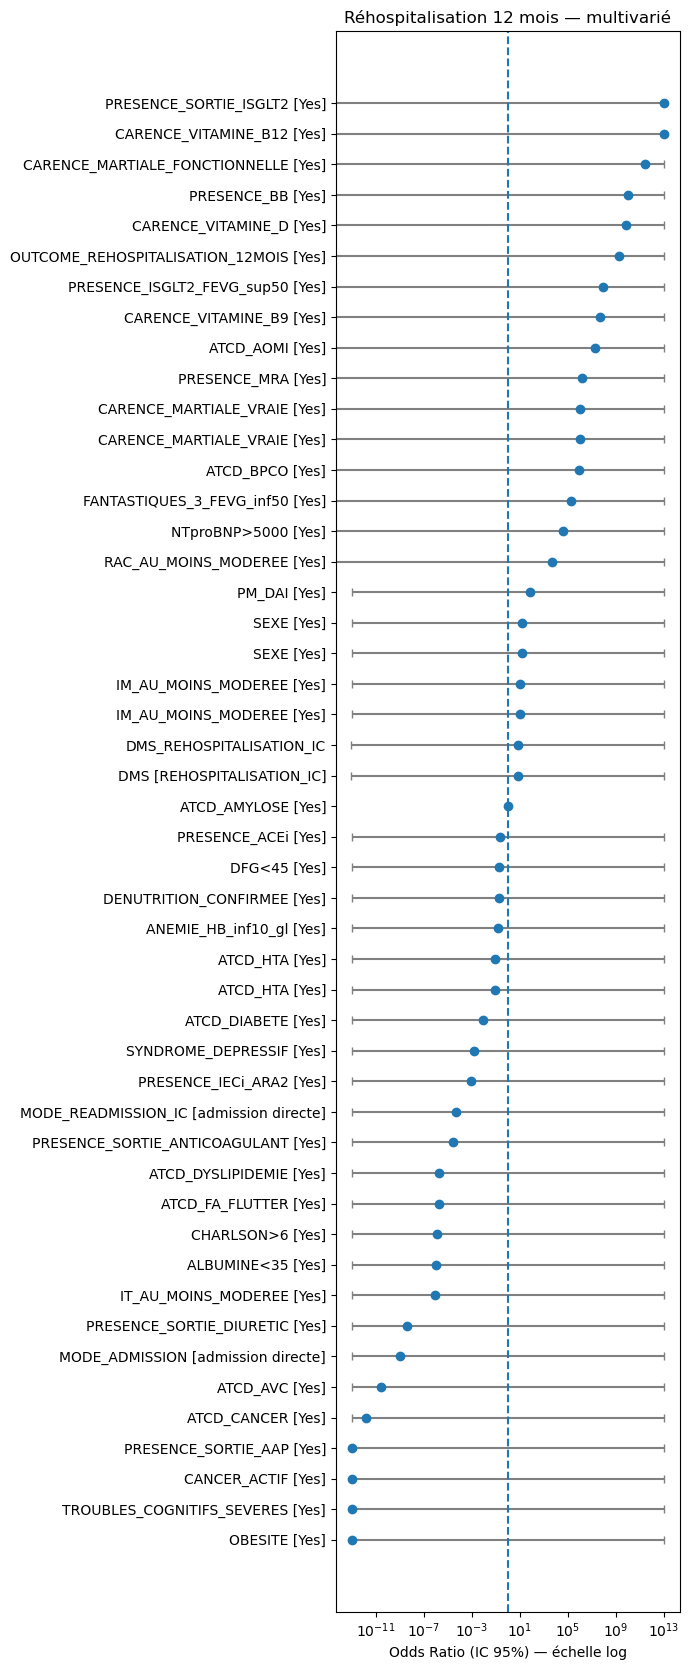

In [48]:
or12 = or_store['REHOSPITALISATION_IC_12MOIS']
forestplot_from_store(or12, title="Réhospitalisation 12 mois — multivarié", logscale=True,
                      save_path="../output/forest_12mois.png")

In [49]:
# 1) Inspecter les valeurs qui alimentent le plot
cols = ["Variable","Level","OR_multi","CI_low","CI_high"]
print(or12[cols].head(30))

# 2) Détecter les cas pathologiques
bad = (
    ~np.isfinite(or12["OR_multi"]) |
    ~np.isfinite(or12["CI_low"])   |
    ~np.isfinite(or12["CI_high"])  |
    (or12["OR_multi"]<=0)          |
    (or12["CI_low"]<=0)            |
    (or12["CI_high"]<=0)           |
    (or12["CI_high"]<or12["CI_low"])
)
or12_bad = or12.loc[bad, cols]
print("⚠️ Lignes problématiques:", len(or12_bad))
or12_bad

                      Variable                 Level  \
0                          DMS                   ref   
1                          DMS  REHOSPITALISATION_IC   
2     DMS_REHOSPITALISATION_IC                         
3          MODE_READMISSION_IC                   ref   
4          MODE_READMISSION_IC     admission directe   
5               MODE_ADMISSION                   ref   
6               MODE_ADMISSION     admission directe   
7                         SEXE                   ref   
8                         SEXE                   Yes   
9                         SEXE                   Yes   
10                     OBESITE                   ref   
11                     OBESITE                   Yes   
12       DENUTRITION_CONFIRMEE                   ref   
13       DENUTRITION_CONFIRMEE                   Yes   
14                  CHARLSON>6                   ref   
15                  CHARLSON>6                   Yes   
16          SYNDROME_DEPRESSIF                  

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [50]:
def _to_scalar(v):
    import pandas as pd
    if isinstance(v, pd.Series) and len(v)>0:
        return v.iloc[0]
    if isinstance(v, (list, tuple)) and len(v)>0:
        return v[0]
    return v

or12c = or12.copy()

# enlever les lignes de référence pour le tracé
if "is_ref" in or12c:
    or12c = or12c[~or12c["is_ref"]].copy()
or12c = or12c[or12c["Level"].astype(str).str.lower().ne("ref")].copy()

for col in ["OR_multi","CI_low","CI_high"]:
    or12c[col] = or12c[col].apply(_to_scalar)
    or12c[col] = pd.to_numeric(or12c[col], errors="coerce")

# virer doublons éventuels (même variable/niveau)
or12c = or12c.drop_duplicates(subset=["Variable","Level"])

In [51]:
vals = or12c[["OR_multi","CI_low","CI_high"]].to_numpy(dtype=float)
bad_num  = ~np.isfinite(vals).any(axis=1)  # si tu veux “toute colonne non finie”
bad_nonpos = (vals <= 0).any(axis=1)
bad_order  = (vals[:,2] < vals[:,1])  # CI_high < CI_low
bad = bad_nonpos | bad_order

or12_bad = or12c.loc[bad, ["Variable","Level","OR_multi","CI_low","CI_high"]]
print("⚠️ Lignes problématiques:", len(or12_bad))
display(or12_bad.head(20))

⚠️ Lignes problématiques: 0


,Variable,Level,OR_multi,CI_low,CI_high
